In [13]:
CHECKPOINT_PATH='/local/home/ekoller/sam_data/sam_vit_b_01ec64.pth'


import torch
import os 
import glob
import random
import pickle
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os.path as osp
from collections import Counter
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_b"

cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")
DEVICE = torch.device('cuda:0' if cuda_available else 'cpu')
print(f"Using device: {DEVICE}")


data_dir ='/local/home/ekoller/R3Scan'
scenes_dir = '/local/home/ekoller/R3Scan/scenes'
scan_id= "38770c95-86d7-27b8-8717-3485b411ddc7" #is reference scan  since it is a reference scan everything shouls be correctly hit
curr_scan_id = "38770c9d-86d7-27b8-869e-4f713b04f290" 
new_scan_id =  "38770c95-86d7-27b8-8717-3485b411ddc7"
frame_number = "000015"
patch_height = 30 #540/9
patch_width = 30 #960/16




CUDA available: True
Using device: cuda:0


this part does the sam stuff for only one image based on sam segmentation

In [43]:
def show_output(result_dict,axes=None):
     if axes:
        ax = axes
     else:
        ax = plt.gca()
        ax.set_autoscale_on(False)
     sorted_result = sorted(result_dict, key=(lambda x: x['area']),      reverse=True)
     # Plot for each segment area
     for val in sorted_result:
        mask = val['segmentation']
        img = np.ones((mask.shape[0], mask.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
            ax.imshow(np.dstack((img, mask*0.5)))

In [35]:
#to make the mesh more accurate we provide a dense point grid
def create_dense_uniform_grid(points_per_side):
    """Generates a 2D grid of points evenly spaced in [0,1]x[0,1]."""
    offset = 1 / (2 * points_per_side)
    points_one_side = np.linspace(offset, 1 - offset, points_per_side)
    points_x = np.tile(points_one_side[None, :], (points_per_side, 1))
    points_y = np.tile(points_one_side[:, None], (1, points_per_side))
    points = np.stack([points_x, points_y], axis=-1).reshape(-1, 2)
    return points
   

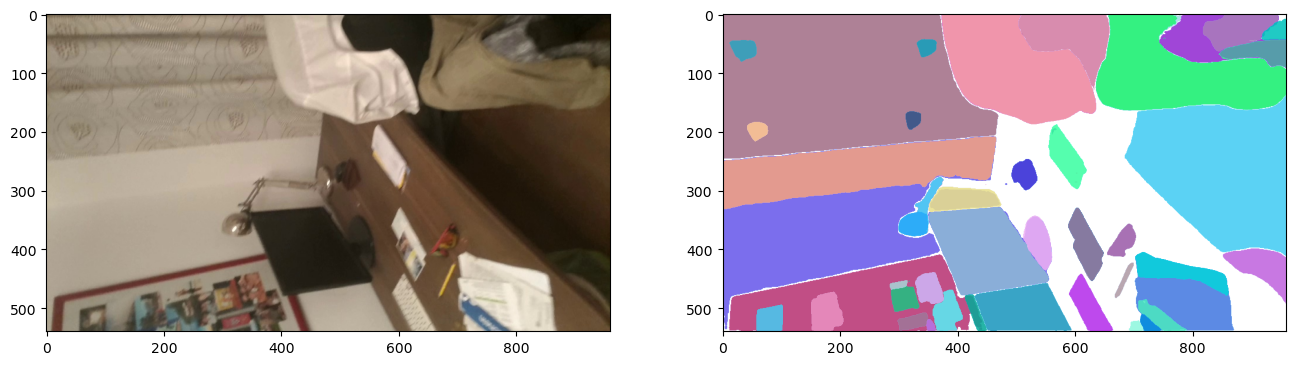

In [51]:
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)


IMAGE_PATH= osp.join(data_dir,"scenes",scan_id,"sequence","frame-"+str(frame_number)+".color.jpg")
# Read the image from the path
image= cv2.imread(IMAGE_PATH)
# Convert to RGB format
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
grid = create_dense_uniform_grid(50)


# Generate segmentation mask
mask_generator = SamAutomaticMaskGenerator(model = sam,   points_per_side= None,  point_grids = [create_dense_uniform_grid(200)])

output_mask = mask_generator.generate(image_rgb)
#print(output_mask)

_,axes = plt.subplots(1,2, figsize=(16,16))
axes[0].imshow(image_rgb)
show_output(output_mask, axes[1])

This codesegment will do the following: for the projection of the current scene do the bounding boxes IMPORTANT: LOOK IN THE RAY INTERSECTION FILE FIRST THAT THE PROJECTION EXISTS!!



In [3]:
# load the sam tools
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)


mask_generator = SamAutomaticMaskGenerator(sam)


#generate the mask for the image
# Give the path of your imag

IMAGE_PATH= osp.join(data_dir, "proj", curr_scan_id, "color", "proj_pose_"+ str(new_scan_id)+"_"+str(frame_number)+".jpg")
print("image path", IMAGE_PATH)
# Read the image from the path
image= cv2.imread(IMAGE_PATH)
# Convert to RGB format
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


# Generate segmentation mask
try:
    # Clear GPU cache
    torch.cuda.empty_cache()

    # Generate segmentation mask
    output_mask = mask_generator.generate(image_rgb)
    print(output_mask)

except RuntimeError as e:
    if 'out of memory' in str(e):
        print('CUDA out of memory. Consider reducing batch size or model complexity.')
        torch.cuda.empty_cache()
    else:
        raise e
    



image path /local/home/ekoller/R3Scan/proj/38770c9d-86d7-27b8-869e-4f713b04f290/color/proj_pose_38770c95-86d7-27b8-8717-3485b411ddc7_000015.jpg


[ WARN:0@15.888] global loadsave.cpp:248 findDecoder imread_('/local/home/ekoller/R3Scan/proj/38770c9d-86d7-27b8-869e-4f713b04f290/color/proj_pose_38770c95-86d7-27b8-8717-3485b411ddc7_000015.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [11]:
# Function that inputs the output and plots image and mask
def show_output(result_dict,axes=None):
     if axes:
        ax = axes
     else:
        ax = plt.gca()
        ax.set_autoscale_on(False)
     sorted_result = sorted(result_dict, key=(lambda x: x['area']),      reverse=True)
     # Plot for each segment area
     for val in sorted_result:
        mask = val['segmentation']
        img = np.ones((mask.shape[0], mask.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
            ax.imshow(np.dstack((img, mask*0.5)))

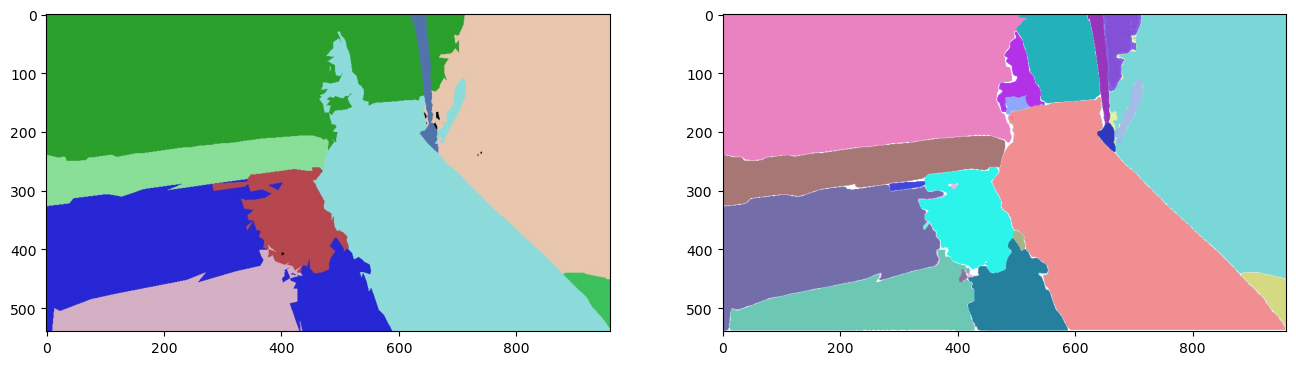

In [12]:
_,axes = plt.subplots(1,2, figsize=(16,16))
axes[0].imshow(image_rgb)
show_output(output_mask, axes[1])

this segment is for the boundingboxes of the reference scans for which we already have the projection ground truth -> take the ground truth, quantize it and then produce the boundingboxes

In [14]:
#this codesegment takes in a semantic segmentation of the projection with sam and translates it into the object ids
def bounding_boxes_for_projection(data_dir, curr_scan_id, frame_number):
    #access the projection

    proj_rgb= osp.join(data_dir, "files/gt_projection", "obj_id", curr_scan_id,"frame-"+str(frame_number)+".jpg")
    obj_mat = cv2.imread(proj_rgb, cv2.IMREAD_UNCHANGED)
    img_height, img_width= obj_mat.shape
    new_id = np.zeros_like(obj_mat)
    
    for h in range(0, img_height, patch_height):
        for w in range(0, img_width, patch_width):
            patch = obj_mat[h:h+patch_height, w:w+patch_width]
             # flatten the array to 1d
            flattened_patch = patch.flatten()
             # Find the most common value
            value_counts = Counter(flattened_patch)
            most_common_value = value_counts.most_common(1)[0][0]
            # Fill the patch with the most common color
            new_id[h:h+patch_height, w:w+patch_width] = most_common_value


   

    #compute the boundingboxes based on that new obj_id_mask
    bounding_boxes = []
    unique_ids = np.unique(new_id)
    print("unique ids", unique_ids)

    #print also the unique ids of the pkl scenegraph
    pklfile = osp.join('/local/home/ekoller/R3Scan', 'files', 'orig', 'data', '{}.pkl'.format(scan_id) )
    with open(pklfile, "rb") as f:
            # Load the data
            data = pickle.load(f)
            object_id_pkl = data["objects_id"]
    print("object ids from graph", object_id_pkl)



    for obj_id in unique_ids:
        # Create mask for current object ID
        mask = (new_id == obj_id)

        # Find bounding box coordinates
        rows, cols = np.nonzero(mask)
        if len(rows) > 0 and len(cols) > 0:
            min_row, max_row = np.min(rows) - (patch_height), np.max(rows) + (patch_height)
            min_col, max_col = np.min(cols) - (patch_width), np.max(cols) + (patch_width)

            # Calculate height and width
            height = max_row - min_row + 1
            width = max_col - min_col +1

            # Store bounding box information
            bounding_boxes.append({
                'object_id': obj_id,
                'bbox': [min_col, min_row, width, height]
            })

    



    #this part is only to sanity check how the values look like but for efficiecy reasons we compute the boxes based on only the object id
    proj_rgb= osp.join(data_dir, "files/gt_projection", "color", curr_scan_id,"frame-"+str(frame_number)+".jpg")
    rgb_img = cv2.imread(proj_rgb, cv2.IMREAD_UNCHANGED)
    img_height, img_width, _ = rgb_img.shape
    new_image = np.zeros_like(rgb_img)

    #add the object ids which are visible in the graph from the preprocessing!!
    
    for h in range(0, img_height, patch_height):
        for w in range(0, img_width, patch_width):
            patch = rgb_img[h:h+patch_height, w:w+patch_width]
             # Reshape patch to a 2D array of shape (num_pixels, 3)
            reshaped_patch = patch.reshape(-1, patch.shape[2])
            
            # Find the most common color
            color_counts = Counter(map(tuple, reshaped_patch))
            most_common_color = color_counts.most_common(1)[0][0]
            # Fill the patch with the most common color
            new_image[h:h+patch_height, w:w+patch_width] = most_common_color

    cv2.imshow('Imag()e patchwise', new_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows

    return bounding_boxes
                       

bounding_boxes_for_projection(data_dir, curr_scan_id, frame_number)
 


    


unique ids [ 1  8  9 15 16 25 26 28 29]
object ids from graph [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  29  30  31  32  33  34  35  38  39
  40  41 100 101 102]


QObject::moveToThread: Current thread (0x561415155e70) is not the object's thread (0x561413577f80).
Cannot move to target thread (0x561415155e70)

QObject::moveToThread: Current thread (0x561415155e70) is not the object's thread (0x561413577f80).
Cannot move to target thread (0x561415155e70)

QObject::moveToThread: Current thread (0x561415155e70) is not the object's thread (0x561413577f80).
Cannot move to target thread (0x561415155e70)

QObject::moveToThread: Current thread (0x561415155e70) is not the object's thread (0x561413577f80).
Cannot move to target thread (0x561415155e70)

QObject::moveToThread: Current thread (0x561415155e70) is not the object's thread (0x561413577f80).
Cannot move to target thread (0x561415155e70)

QObject::moveToThread: Current thread (0x561415155e70) is not the object's thread (0x561413577f80).
Cannot move to target thread (0x561415155e70)

QObject::moveToThread: Current thread (0x561415155e70) is not the object's thread (0x561413577f80).
Cannot move to tar

[{'object_id': 1, 'bbox': [510, -30, 480, 510]},
 {'object_id': 8, 'bbox': [-30, -30, 690, 600]},
 {'object_id': 9, 'bbox': [-30, 30, 300, 270]},
 {'object_id': 15, 'bbox': [240, -30, 540, 390]},
 {'object_id': 16, 'bbox': [390, 240, 600, 330]},
 {'object_id': 25, 'bbox': [510, 60, 210, 180]},
 {'object_id': 26, 'bbox': [120, -30, 180, 150]},
 {'object_id': 28, 'bbox': [330, 120, 90, 90]},
 {'object_id': 29, 'bbox': [300, 450, 180, 120]}]

In [15]:
#display the newly computed bounding boxes 
bboxes = bounding_boxes_for_projection(data_dir, curr_scan_id, frame_number)
# print(" bounding boxes ",bboxes)

#access the computed boundingboxes
#bboxes = np.load( osp.join(data_dir, "bboxes", curr_scan_id, "gt_projection","frame-"+str(frame_number)+".npy"))
#access the projection
proj_rgb= osp.join(data_dir, "scenes", curr_scan_id, "sequence","frame-"+str(frame_number)+".color.jpg")
rgb_img = cv2.imread(proj_rgb, cv2.IMREAD_COLOR)

# Draw bounding boxes and object IDs
for box in bboxes:
        min_col, min_row, width, height = box['bbox']
        min_col, min_row, width, height = int(min_col), int(min_row), int(width), int(height)
        color = np.random.randint(0, 256, 3).tolist()
        cv2.rectangle(rgb_img, (min_col, min_row), (min_col + width, min_row + height), color, 2)
        cv2.putText(rgb_img, str(box['object_id']), (min_col, min_row  - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# Display the image
cv2.imshow('Image with Bounding Boxes', rgb_img)
cv2.waitKey(0)
cv2.destroyAllWindows()


unique ids [ 1  8  9 15 16 25 26 28 29]
object ids from graph [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  29  30  31  32  33  34  35  38  39
  40  41 100 101 102]


QObject::moveToThread: Current thread (0x561415155e70) is not the object's thread (0x561413577f80).
Cannot move to target thread (0x561415155e70)

QObject::moveToThread: Current thread (0x561415155e70) is not the object's thread (0x561413577f80).
Cannot move to target thread (0x561415155e70)

QObject::moveToThread: Current thread (0x561415155e70) is not the object's thread (0x561413577f80).
Cannot move to target thread (0x561415155e70)

QObject::moveToThread: Current thread (0x561415155e70) is not the object's thread (0x561413577f80).
Cannot move to target thread (0x561415155e70)

QObject::moveToThread: Current thread (0x561415155e70) is not the object's thread (0x561413577f80).
Cannot move to target thread (0x561415155e70)

QObject::moveToThread: Current thread (0x561415155e70) is not the object's thread (0x561413577f80).
Cannot move to target thread (0x561415155e70)

QObject::moveToThread: Current thread (0x561415155e70) is not the object's thread (0x561413577f80).
Cannot move to tar

this segment does the reading in to the sam framework
to do: save also the  image that we get
find out what we need exactly, this is for the input images!!


In [27]:

def generate_sam_data(path_to_img):

    sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)


    mask_generator = SamAutomaticMaskGenerator(sam)

    # Give the path of your image
    IMAGE_PATH= osp.join(path_to_img)
    # Read the image from the path
    image= cv2.imread(IMAGE_PATH)
    # Convert to RGB format
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Generate segmentation mask
    try:
        # Clear GPU cache
        torch.cuda.empty_cache()

        # Generate segmentation mask
        output_mask = mask_generator.generate(image_rgb)
        print(output_mask)

    except RuntimeError as e:
        if 'out of memory' in str(e):
            print('CUDA out of memory. Consider reducing batch size or model complexity.')
            torch.cuda.empty_cache()
        else:
            raise e
        
    return output_mask

In [28]:
#returns for every semantic regtion of thet frame x_min,x_max, y_min, y_max, height, width
def get_sam_boundingboxes_frame(path_to_img):

    data_dict = generate_sam_data(path_to_img)
    #print("sam ressult", data_dict)

    bboxes = []
     #iterate through evey segmentation field to get the result
    for val in data_dict:
        bbox = val['bbox']
        x_min, y_min, width, height = bbox
        x_max = x_min + width
        y_max = y_min + height
        bboxes.append(np.array([x_min,x_max, y_min, y_max, height, width]))


    return bboxes

In [29]:
#wil be called by the rescan input image
def get_all_sam_semantic_boxes_scene(data_dir, scan_id):

    #go to the folder of the scene
    folder_path = osp.join(data_dir, "scenes", scan_id, "sequence")
    print("folderpath", folder_path)
    file_pattern = 'frame-*.color.jpg'


    #search for all the colour files
    file_list = glob.glob(os.path.join(folder_path, file_pattern))
    print("file list", file_list)

    #create a directory in which the boxes get saved
    output_path = osp.join(data_dir, "sam_data", scan_id, "bboxes")
    try:
        os.makedirs(output_path, exist_ok=True)
    except Exception as e:
        print(f"Failed to create directory {output_path}: {e}")

    for file in file_list:
        frame_boxes = get_sam_boundingboxes_frame(file)

        #get the name of the file currently accessed
        filename = os.path.basename(file)
        pattern_part = filename.split('.')[0]

        filename = pattern_part + ".npy"
        #make a new file to save the information of the boundingboxes
        box_file_path = osp.join(output_path, filename)
        success_obj = np.save(box_file_path, frame_boxes)
        print("success obj", success_obj)

In [30]:
get_all_sam_semantic_boxes_scene(data_dir,scan_id)

[{'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'area': 406090, 'bbox': [52, 3, 907, 533], 'predicted_iou': 1.002079725265503, 'point_coords': [[645.0, 278.4375]], 'stability_score': 0.9837116003036499, 'crop_box': [0, 0, 960, 540]}, {'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]]), 'area': 1448, 'bbox': [929, 456, 30, 83], 'predicted_iou': 1.0010135173797607, 

KeyboardInterrupt: 

: 

below is unused lol

In [16]:
# Function that inputs the output and plots image and mask
def show_output(result_dict,axes=None):
      if axes:
         ax = axes
      else:
         ax = plt.gca()
         ax.set_autoscale_on(False)
      sorted_result = sorted(result_dict, key=(lambda x: x['area']),      reverse=True)
      # Plot for each segment area
      for val in sorted_result:
         mask = val['segmentation']
         img = np.ones((mask.shape[0], mask.shape[1], 3))
         color_mask = np.random.random((1, 3)).tolist()[0]
         for i in range(3):
               img[:,:,i] = color_mask[i]
               ax.imshow(np.dstack((img, mask*0.5)))
         
         
         # Display bounding box
         bbox = val['bbox']
         x_min, y_min, width, height = bbox
         x_max = x_min + width
         y_max = y_min + height
         rect = plt.Rectangle((x_min, y_min), width, height, fill=False, edgecolor='red', linewidth=2)
         ax.add_patch(rect)
         ax.add_patch(rect)

      # bboxes = get_sam_boundingboxes(data_dir, scan_id, frame_number)
      # for box in bboxes:
      #    x_min,x_max, y_min, y_max, width, height = box
      #    rect = plt.Rectangle((x_min, y_min), width, height, fill=False, edgecolor='red', linewidth=2)
      #    ax.add_patch(rect)
      #    ax.add_patch(rect)
          
      

[{'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'area': 92828, 'bbox': [0, 0, 467, 247], 'predicted_iou': 0.9876569509506226, 'point_coords': [[165.0, 126.5625]], 'stability_score': 0.978972852230072, 'crop_box': [0, 0, 960, 540]}, {'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'area': 1797, 'bbox': [57, 495, 44, 44], 'predicted_iou': 0.9872605800628662, 'po

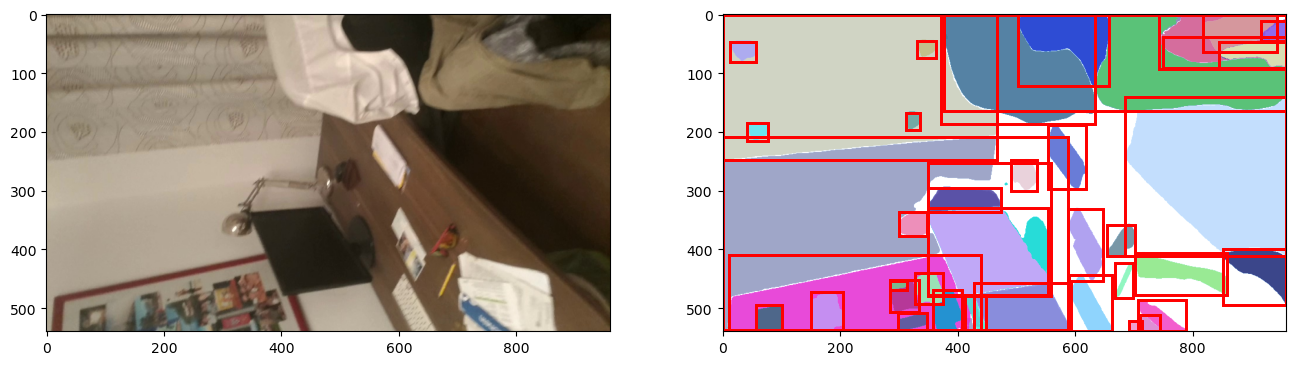

: 

In [17]:
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)


mask_generator = SamAutomaticMaskGenerator(sam)

# Give the path of your image
IMAGE_PATH= osp.join(data_dir,"scenes",new_scan_id,"sequence","frame-"+str(frame_number)+".color.jpg")


# Read the image from the path
image= cv2.imread(IMAGE_PATH)
# Convert to RGB format
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Generate segmentation mask
try:
    # Clear GPU cache
    torch.cuda.empty_cache()

    # Generate segmentation mask
    output_mask = mask_generator.generate(image_rgb)
    print(output_mask)

except RuntimeError as e:
    if 'out of memory' in str(e):
        print('CUDA out of memory. Consider reducing batch size or model complexity.')
        torch.cuda.empty_cache()
    else:
        raise e
_,axes = plt.subplots(1,2, figsize=(16,16))
axes[0].imshow(image_rgb)
show_output(output_mask, axes[1])